In [1]:
import tensorflow as tf
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2024-06-14 13:52:47.738690: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 13:52:47.766112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 13:52:48.303214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


2024-06-14 13:52:48.962590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:48.975788: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:48.975829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Load cifar dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [3]:
# Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
# Convert the label into the categorical crossentropy

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=100)

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
num_classes = 100
input_shape = (32, 32, 3)

# ViT Base
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10  # For real training, use num_epochs=100. 10 is a test value
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12
mlp_head_units = [
    3072,
]

config_json = {   
    "learning_rate" : learning_rate,
    "batch_size" : batch_size,
    "num_epochs" : num_epochs,
    "image_size" : image_size,
    "patch_size" : patch_size,
    "num_patches" : num_patches,
    "projection_dim" : projection_dim,
    "num_heads" : num_heads,
    "final_dropout_layer" : 0.5,
    "transformer_units" : transformer_units,
    "transformer_layers" : transformer_layers,
    "mlp_head_units" : mlp_head_units
}

In [7]:
from modules.vision_transformers.patches import Patches
from modules.vision_transformers.patch_encoder import PatchEncoder, mlp

In [8]:
# Data Augmentation for resize
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Normalization(),
    tf.keras.layers.Resizing(image_size, image_size),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(factor=0.02),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    #tf.keras.layers.RandomContrast(factor=0.1)
])

# Compute the average and variance of the training data for normalization purpose
data_augmentation.layers[0].adapt(x_train)

2024-06-14 13:52:49.373111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:49.373183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:49.373209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:49.446164: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-14 13:52:49.446218: I external/local_xla/xla/stream_executor

In [9]:
# Define the model
def create_classifier():
    inputs = tf.keras.Input(shape=input_shape)

    # Apply augment resize
    augmented = data_augmentation(inputs)
    
    # Create Patches
    patches = Patches(patch_size)(augmented)

    # Encode every patches position
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        # Create multilayers about how many transformers layer needed
        x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    
        # Create a multi-head attention layer
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = tf.keras.layers.Add()([attention_output, encoded_patches])

        # layer normalization 2
        x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)

        # NLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip Connection
        encoded_patches = tf.keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = tf.keras.layers.Flatten()(representation)
    representation = tf.keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = tf.keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

In [10]:
model = create_classifier()

In [11]:
total_steps = len(x_train) * num_epochs
decay_steps = total_steps * 0.4
# Cosine Learning Rate Decay
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=decay_steps,
    alpha=0.1,
    warmup_steps=10000
)

In [12]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=cosine_decay_scheduler),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name='top-5-accuracy')
    ]
)

In [13]:
history = model.fit(
    x=x_train,
    y=y_train_categorical,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(x_test, y_test_categorical)
)

Epoch 1/10


2024-06-14 13:53:23.185160: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 293s 173ms/step - accuracy: 0.0265 - loss: 4.9239 - top-5-accuracy: 0.1071 - val_accuracy: 0.0607 - val_loss: 4.2148 - val_top-5-accuracy: 0.2317
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 265s 170ms/step - accuracy: 0.0453 - loss: 4.2588 - top-5-accuracy: 0.1763 - val_accuracy: 0.1374 - val_loss: 3.6702 - val_top-5-accuracy: 0.3698
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 265s 170ms/step - accuracy: 0.1470 - loss: 3.6275 - top-5-accuracy: 0.3823 - val_accuracy: 0.2433 - val_loss: 3.0676 - val_top-5-accuracy: 0.5382
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 261s 167ms/step - accuracy: 0.2263 - loss: 3.1539 - top-5-accuracy: 0.5198 - val_accuracy: 0.2941 - val_loss: 2.8539 - val_top-5-accuracy: 0.5917
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 259s 166ms/step - accuracy: 0.2795 - loss: 2.9151 - top-5-accuracy: 0.5771 - val_accuracy: 0.3239 - val_loss: 2.6744 - val_top-5-accuracy: 0.6286
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 260s 166ms/step - accuracy: 0

In [14]:
evaluated = model.evaluate(x_test, y_test_categorical)
final_acc, final_loss, final_top_3_acc = evaluated[0], evaluated[1], evaluated[2]

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4091 - loss: 2.3127 - top-5-accuracy: 0.7092


In [15]:
save_name = 'model/model_base_vit_cifar100_val'

In [16]:
history.history

{'accuracy': [0.03180000185966492,
  0.05708000063896179,
  0.1709199994802475,
  0.23654000461101532,
  0.28213998675346375,
  0.3124600052833557,
  0.3425599932670593,
  0.36403998732566833,
  0.38763999938964844,
  0.4059000015258789],
 'loss': [4.49999475479126,
  4.174919128417969,
  3.4912071228027344,
  3.110159397125244,
  2.892437219619751,
  2.728440284729004,
  2.5900590419769287,
  2.4724860191345215,
  2.369495153427124,
  2.267557144165039],
 'top-5-accuracy': [0.1301400065422058,
  0.20679999887943268,
  0.425680011510849,
  0.5320000052452087,
  0.5831999778747559,
  0.6209400296211243,
  0.6518200039863586,
  0.6790599822998047,
  0.7005000114440918,
  0.7216200232505798],
 'val_accuracy': [0.06069999933242798,
  0.13740000128746033,
  0.24330000579357147,
  0.29409998655319214,
  0.3239000141620636,
  0.3564000129699707,
  0.3644999861717224,
  0.38019999861717224,
  0.3968000113964081,
  0.4077000021934509],
 'val_loss': [4.214814186096191,
  3.670182466506958,
  3.0

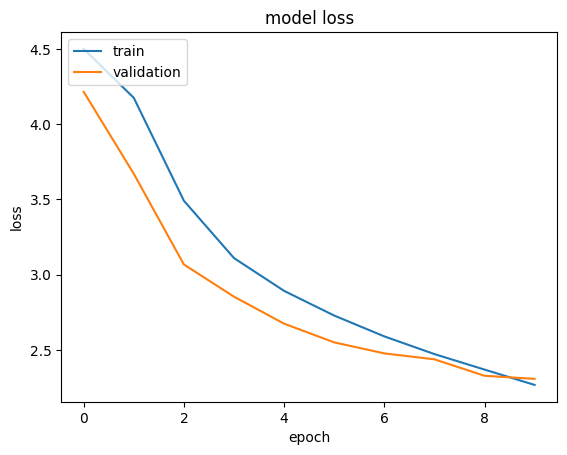

In [17]:
import matplotlib.pyplot as plt

# Save Train result
fig = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
fig.savefig(save_name + "_loss.jpg")

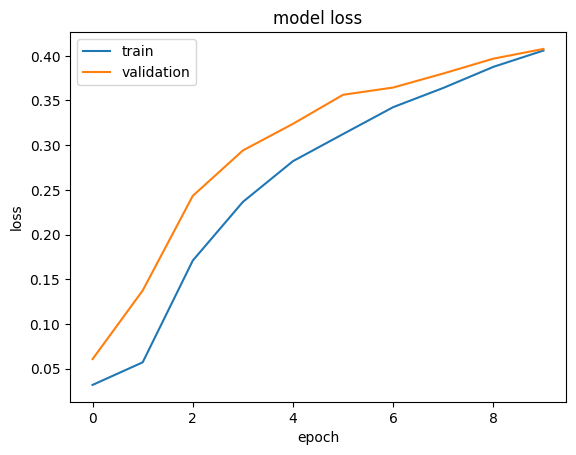

In [19]:
# Save Train result
fig = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
fig.savefig(save_name + "_accuracy.jpg")

In [21]:
model.save('{}.keras'.format(save_name))

In [22]:
import json

config_json['final_accuracy'] = final_acc,
config_json['final_loss'] = final_loss
config_json['final_top_3_acc'] = final_top_3_acc
with open('{}_config.json'.format(save_name), 'w') as f:
    json.dump(config_json, f, indent=4)